# Imports

In [1]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# sanity check
project_config["TKL"]

'AAPL'

# Download TKL data from YF

In [4]:
from datetime import date, timedelta
end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

In [5]:
tickers_yf = {
    "y"           : f"{project_config['TKL']}",
    "NASDAQ"      : "^IXIC",
    "SP500"       : "^GSPC",
    "RealEstate"  : "VNQ",
    "Oil_WTI"     : "CL=F",
    "Gold": "GC=F"
}

tickers_fred = {
 #   "Inflation_CPI" : "CPIAUCSL",
 #   "Unemployment"  : "UNRATE"
}

In [6]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# ---- DOWNLOAD FROM YAHOO FINANCE ----
ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True
)["Close"]

# rename columns to readable names
ts_yf.columns = list(tickers_yf.keys())

# ---- DOWNLOAD FROM FRED ----
ts_fred = pd.DataFrame()
for name, fred_code in tickers_fred.items():
    ts_fred[name] = pdr.DataReader(fred_code, "fred", start_date, end_date)


# ---- MERGE ALL ----
ts = pd.concat([ts_yf, ts_fred], axis=1)

# Fill missing daily values for macro data (monthly)
ts = ts.ffill()  # forward fill
ts = ts.dropna()  # drop any remaining rows

ts = ts.reset_index().rename(columns={"Date": "Date"})

display(ts.head(1))
display(ts.tail(1))

[*********************100%***********************]  6 of 6 completed


,Date,y,NASDAQ,SP500,RealEstate,Oil_WTI,Gold
0,2006-10-06,2.225935,59.759998,572.400024,32.947617,1349.589966,2299.98999


,Date,y,NASDAQ,SP500,RealEstate,Oil_WTI,Gold
4823,2025-12-04,280.700012,59.669998,4211.799805,89.980003,6857.120117,23505.140625


# Turn time series into supprvied learning table

In [7]:
lags = [1,5,10,22,65] # lookback days
windows =  [5,10,22,65] # statistics windows

df = ts.copy()

# Identify columns to generate features for (excluding 'Date')
feature_base_cols = [c for c in df.columns if c not in ['Date']]

for base_col in feature_base_cols: # Iterate over TKL cols

  # Generate lagged features for the current base_col
  for lag in lags:
    df[f"{base_col}_lag_{lag}"] = df[base_col].shift(lag)

  # Generate rolling window statistics for the current base_col
  for window in windows:
    df[f"{base_col}_min_{window}"] = df[base_col].rolling(window=window).min()
    df[f"{base_col}_max_{window}"] = df[base_col].rolling(window=window).max()
    df[f"{base_col}_mean_{window}"] = df[base_col].rolling(window=window).mean()
    df[f"{base_col}_std_{window}"]  = df[base_col].rolling(window=window).std()
    df[f"{base_col}_diff_{window}"] = df[base_col].diff(window)
    df[f"{base_col}_pct_{window}"] = df[base_col].pct_change(window)


df['y_next'] = df['y'].shift(-1)    # tomorrow's price
df.tail(1)['y_next'] = -1           # the target cell

df.dropna(inplace=True)

# Drop 'Date' column from X, along with 'y' and 'y_next'
X = df.drop(['Date', 'y','y_next'], axis=1)
y = df['y_next']

In [8]:
X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4756, 179), (1, 179), (4756,), (1,))

# Train, Predict, Evaluate

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 2.400970458984375


In [11]:
last_row = X_test # Use X_test which was successfully predicted upon
tomorrow_prediction = xgb.predict(last_row)[0]
tomorrow_prediction

np.float32(278.29904)

# Feature selection

<Figure size 1000x600 with 0 Axes>

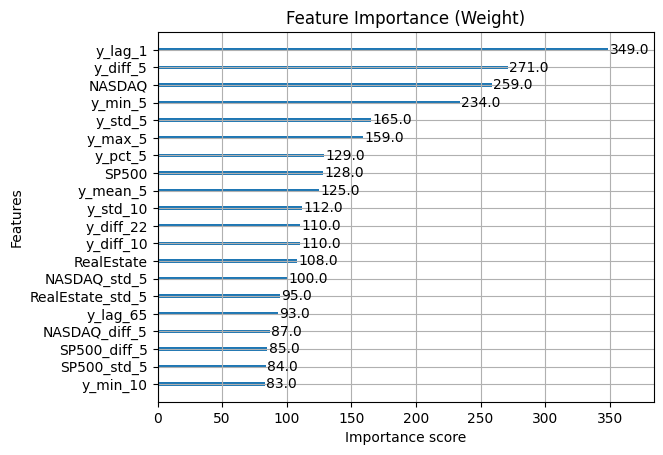

['y_lag_1', 'y_diff_5', 'NASDAQ', 'y_min_5', 'y_std_5', 'y_max_5', 'y_pct_5', 'SP500', 'y_mean_5', 'y_std_10', 'y_diff_10', 'y_diff_22', 'RealEstate', 'NASDAQ_std_5', 'RealEstate_std_5']


In [12]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_weight_features_list = df_importance['Feature'].head(15).tolist()
print(top_weight_features_list)

<Figure size 1000x600 with 0 Axes>

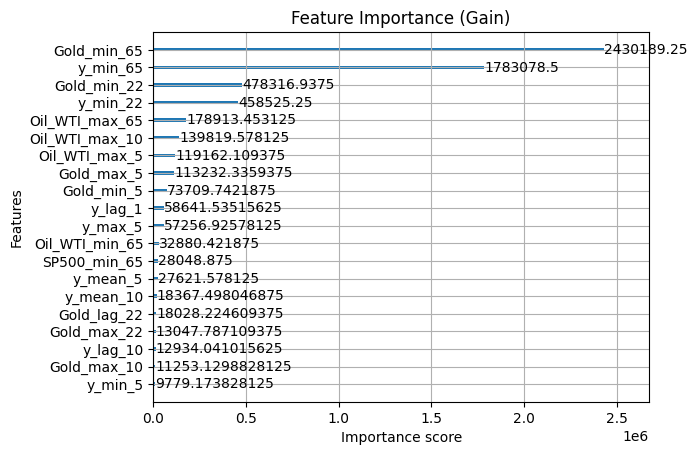

['Gold_min_65', 'y_min_65', 'Gold_min_22', 'y_min_22', 'Oil_WTI_max_65', 'Oil_WTI_max_10', 'Oil_WTI_max_5', 'Gold_max_5', 'Gold_min_5', 'y_lag_1', 'y_max_5', 'Oil_WTI_min_65', 'SP500_min_65', 'y_mean_5', 'y_mean_10']


In [13]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='gain')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_gain_features_list = df_importance['Feature'].head(15).tolist()
print(top_gain_features_list)

In [14]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
top_features

['Gold_min_65',
 'y_diff_10',
 'RealEstate',
 'Oil_WTI_max_5',
 'Gold_min_22',
 'y_pct_5',
 'Gold_min_5',
 'y_diff_5',
 'y_min_65',
 'y_mean_10',
 'y_std_5',
 'y_std_10',
 'Oil_WTI_min_65',
 'y_max_5',
 'NASDAQ_std_5',
 'SP500',
 'y_min_5',
 'NASDAQ',
 'y_mean_5',
 'y_lag_1',
 'RealEstate_std_5',
 'SP500_min_65',
 'Oil_WTI_max_65',
 'Oil_WTI_max_10',
 'y_diff_22',
 'y_min_22',
 'Gold_max_5']

# Final df

In [15]:
final_df = df[['Date','y_next','y'] + top_features]
final_df

,Date,y_next,y,Gold_min_65,y_diff_10,RealEstate,Oil_WTI_max_5,Gold_min_22,y_pct_5,Gold_min_5,...,NASDAQ,y_mean_5,y_lag_1,RealEstate_std_5,SP500_min_65,Oil_WTI_max_65,Oil_WTI_max_10,y_diff_22,y_min_22,Gold_max_5
65,2007-01-10,2.873142,2.909132,2308.270020,0.464562,35.623478,1418.339966,2401.179932,0.157518,2434.250000,...,54.020000,2.673702,2.776271,0.401774,571.900024,1427.089966,1426.839966,0.298713,2.425376,2459.330078
66,2007-01-11,2.837753,2.873142,2308.270020,0.428272,36.085648,1423.819946,2401.179932,0.118375,2434.250000,...,51.880001,2.734524,2.909132,0.599348,571.900024,1427.089966,1424.729980,0.226132,2.425376,2484.850098
67,2007-01-12,2.912129,2.837753,2308.270020,0.412376,36.200047,1430.729980,2401.179932,0.112522,2438.199951,...,52.990002,2.791927,2.873142,0.618193,572.299988,1430.729980,1430.729980,0.176048,2.425376,2502.820068
68,2007-01-16,2.847650,2.912129,2330.790039,0.367690,36.712551,1431.900024,2401.179932,0.136070,2443.830078,...,51.209999,2.861685,2.837753,0.586586,576.299988,1431.900024,1431.900024,0.328701,2.425376,2502.820068
69,2007-01-17,2.671302,2.847650,2330.790039,0.303210,36.698826,1431.900024,2401.179932,0.025710,2459.330078,...,52.240002,2.875961,2.912129,0.457285,579.700012,1431.900024,1431.900024,0.176948,2.425376,2502.820068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,2025-11-26,278.850006,277.549988,21279.630859,4.079987,91.040001,6812.609863,22078.050781,0.033475,22078.050781,...,58.650002,273.635999,276.970001,1.122921,3404.600098,6890.890137,6812.609863,9.000336,266.250000,23214.689453
4819,2025-11-28,283.100006,278.850006,21279.630859,5.899994,91.339996,6849.089844,22078.050781,0.047324,22273.080078,...,58.549999,276.156000,277.549988,0.767431,3431.800049,6890.890137,6849.089844,10.110535,266.250000,23365.689453
4820,2025-12-01,286.190002,283.100006,21279.630859,10.690002,90.290001,6849.089844,22078.050781,0.042764,22872.009766,...,59.320000,278.478003,278.850006,0.604177,3473.699951,6890.890137,6849.089844,13.661194,266.250000,23365.689453
4821,2025-12-02,284.149994,286.190002,21279.630859,18.730011,89.970001,6849.089844,22078.050781,0.037221,23025.589844,...,58.639999,280.532001,283.100006,0.552294,3549.399902,6890.890137,6849.089844,15.052856,266.250000,23413.669922


# Pickle, CSV

In [16]:
df_pickle_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df.pkl"
df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"

final_df.to_pickle(df_pickle_path)
final_df.to_csv(df_csv_path)